# Van der Pol Model

We consider the system $$\begin{cases}\dot{x} = y\\ \dot{y} =\mu(1-x^2)y-x\end{cases}$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

## Mu = 1

#### Van der Pol single trajectory

In [3]:
np.random.seed(1)
MU=1
IC=[0,2.2] #[y0,y_prime]
T = 1000

def vdp(t,y):
    dydt= np.array([y[1], MU*(1-y[0]**2)*y[1]-y[0]])
    return dydt
t_eval = np.arange(0, T, 0.1)
sol = solve_ivp(vdp, [0, T], IC, t_eval=t_eval)
y = sol.y
y0 = np.array(y[0])
y1 = np.array(y[1])
noise0=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))
noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))

#vdp_data = np.transpose(np.vstack((y0,y1,y0+y1+noise0,y0-y1+noise1)))
vdp_data = np.transpose(np.vstack((y0,y1,y0,y1)))

### rSLDS model

In [4]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

/Users/marvynbailly/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get Inferred States

In [5]:
# Global parameters
K = 2
D_obs = 4
D_latent = 2

data = vdp_data

In [6]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)
q_elbos_lem, q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, data)))
zhat_lem = rslds.most_likely_states(xhat_lem, data)

# store rslds
rslds_lem = copy.deepcopy(rslds)

ELBO: 323465.0: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]  


In [11]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)

q_elbos_bbvi, q_bbvi = rslds.fit(data, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=100)

ELBO: -6597865575926923.0: 100%|██████████| 100/100 [00:04<00:00, 24.01it/s]


In [12]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, vdp_data)

### Plots

Text(0, 0.5, 'S(t)')

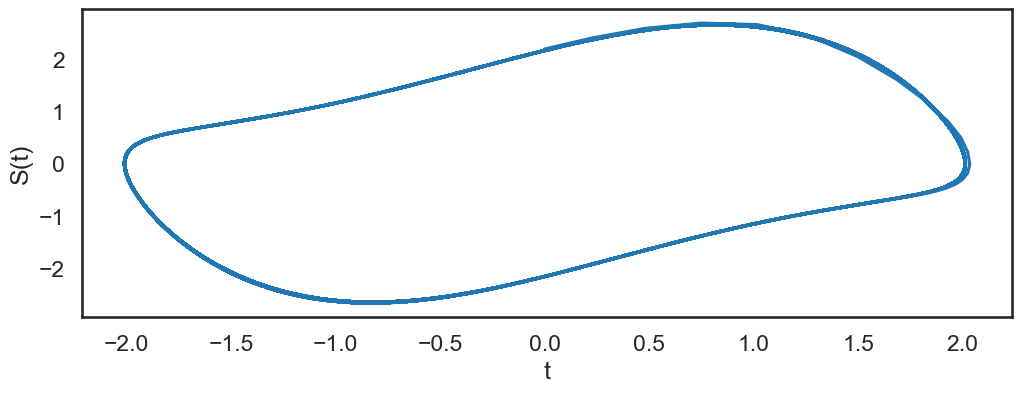

In [13]:
plt.figure(figsize = (12, 4))
plt.plot(sol.y[0], sol.y[1])
plt.xlabel('t')
plt.ylabel('S(t)')

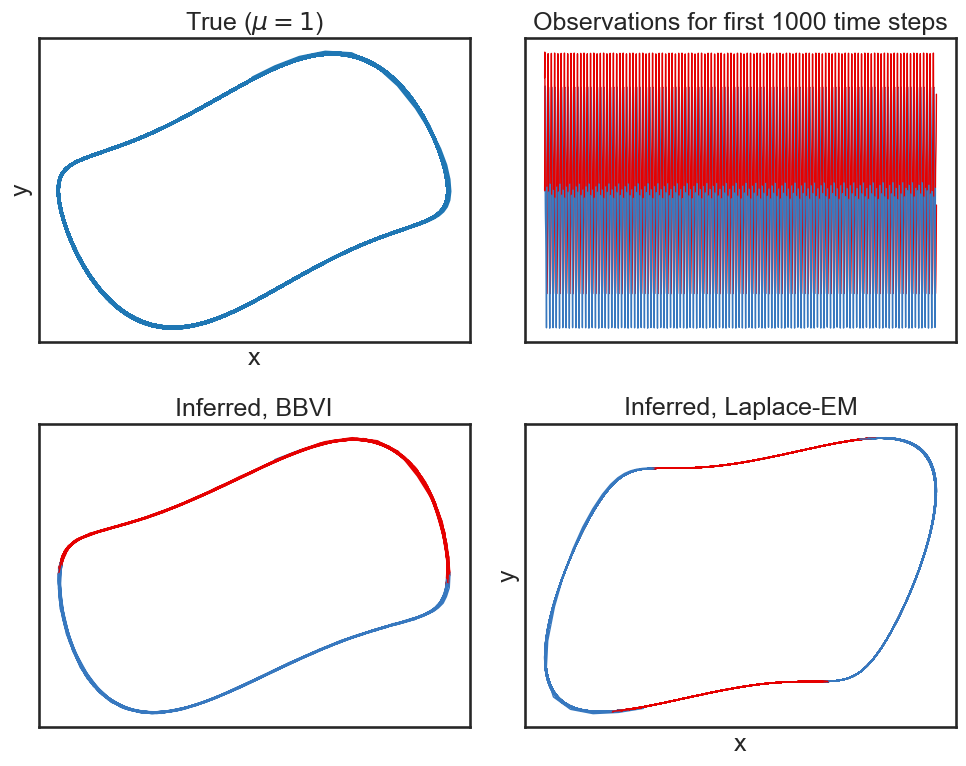

In [14]:
plt.figure(figsize=[10,8])
ax1 = plt.subplot(221)
x=y.T
z=(y1>y1.mean()).astype(int)
ax1.plot(y0, y1)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
plt.title(r"True ($\mu=1$)")
ax2 =plt.subplot(222)
plot_observations(z[:8000], vdp_data[:8000,:2], ax=ax2)
plt.title("Observations for first 1000 time steps")
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(223)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax3)
plt.title("Inferred, BBVI")
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(224)
plot_trajectory(zhat_lem, xhat_lem, ax=ax4)
plt.title("Inferred, Laplace-EM")
plt.xticks([])
plt.yticks([])
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

Text(0.5, 1.0, 'Inferred Dynamics, BBVI')

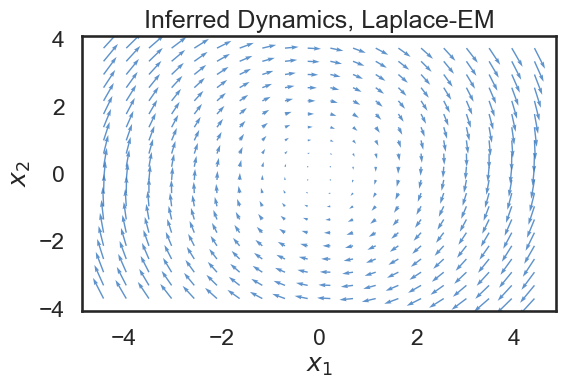

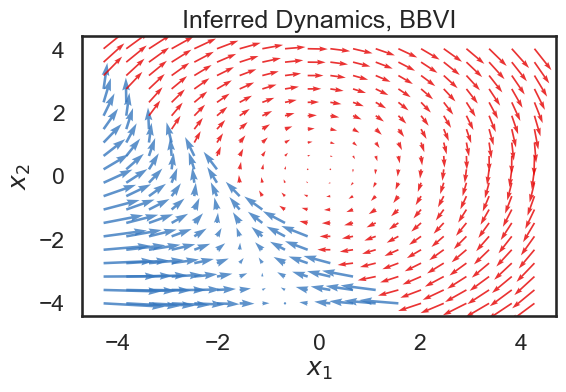

In [43]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_bbvi).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, BBVI")

## Mu = 0

#### Van der Pol single trajectory

In [15]:
np.random.seed(1)
MU=0
IC=[0,2.2] #[y0,y_prime]
T = 1000

def vdp(t,y):
    dydt= np.array([y[1], MU*(1-y[0]**2)*y[1]-y[0]])
    return dydt
t_eval = np.arange(0, T, 0.1)
sol = solve_ivp(vdp, [0, T], IC, t_eval=t_eval)
y = sol.y
y0 = np.array(y[0])
y1 = np.array(y[1])
noise0=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))
noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))

#vdp_data = np.transpose(np.vstack((y0,y1,y0+y1+noise0,y0-y1+noise1)))
vdp_data = np.transpose(np.vstack((y0,y1,y0,y1)))

### rSLDS model

In [16]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

### Get Inferred States

In [17]:
# Global parameters
K = 2
D_obs = 4
D_latent = 2

data = vdp_data

In [18]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)
q_elbos_lem, q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, data)))
zhat_lem = rslds.most_likely_states(xhat_lem, data)

# store rslds
rslds_lem = copy.deepcopy(rslds)

ELBO: 434056.7: 100%|██████████| 100/100 [00:33<00:00,  3.02it/s] 


In [19]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)

q_elbos_bbvi, q_bbvi = rslds.fit(data, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=100)

ELBO: -16061755999066738.0: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


In [20]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, vdp_data)

### Plots

Text(0, 0.5, 'S(t)')

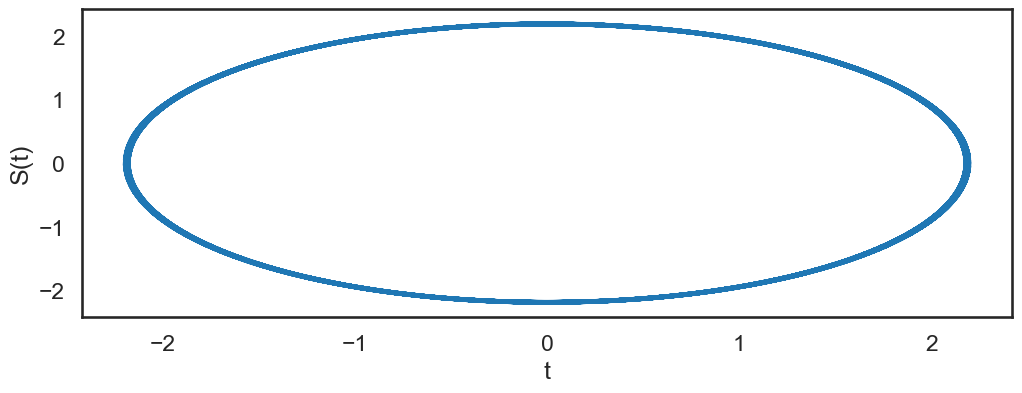

In [21]:
plt.figure(figsize = (12, 4))
plt.plot(sol.y[0], sol.y[1])
plt.xlabel('t')
plt.ylabel('S(t)')

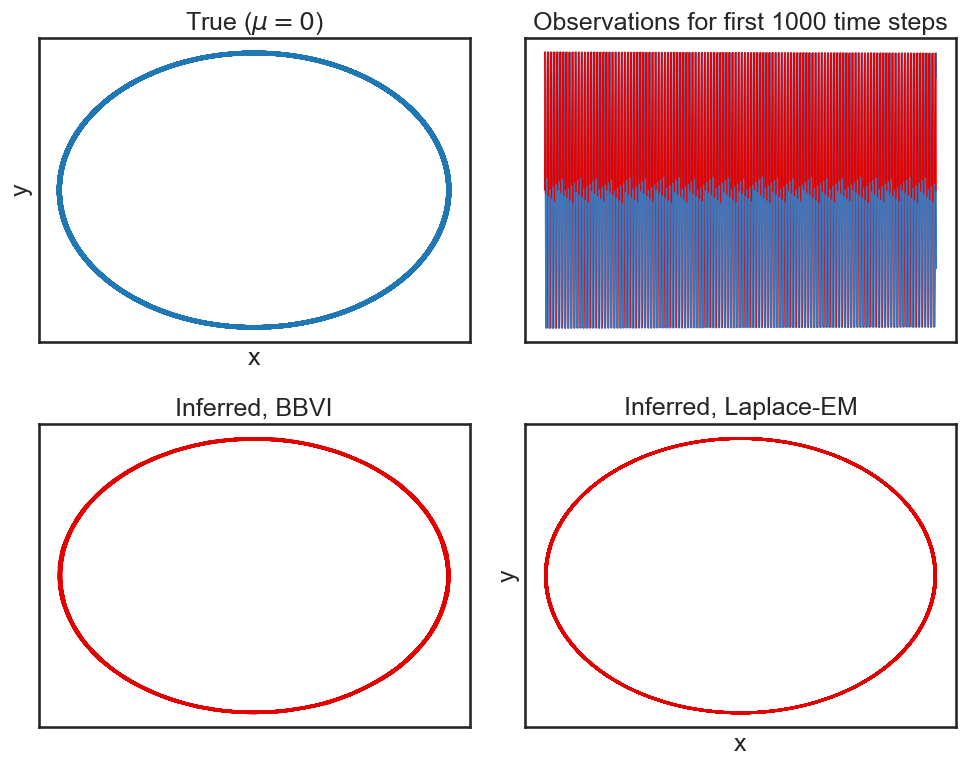

In [22]:
plt.figure(figsize=[10,8])
ax1 = plt.subplot(221)
x=y.T
z=(y1>y1.mean()).astype(int)
ax1.plot(y0, y1)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
plt.title(r"True ($\mu=0$)")
ax2 =plt.subplot(222)
plot_observations(z[:8000], vdp_data[:8000,:2], ax=ax2)
plt.title("Observations for first 1000 time steps")
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(223)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax3)
plt.title("Inferred, BBVI")
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(224)
plot_trajectory(zhat_lem, xhat_lem, ax=ax4)
plt.title("Inferred, Laplace-EM")
plt.xticks([])
plt.yticks([])
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

Text(0.5, 1.0, 'Inferred Dynamics, BBVI')

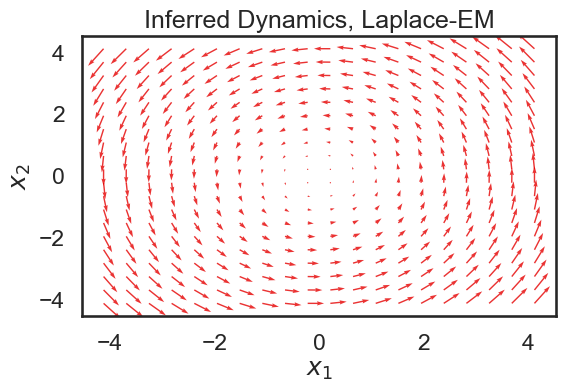

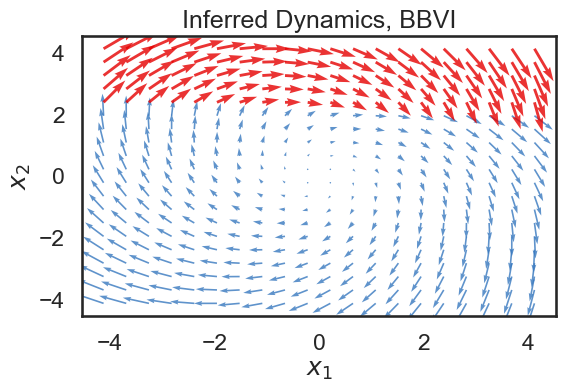

In [52]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_bbvi).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, BBVI")

## Mu = -1

#### Van der Pol single trajectory

In [23]:
np.random.seed(1)
MU=-1
IC=[0,2.115] #[y0,y_prime]
T = 1000

def vdp(t,y):
    dydt= np.array([y[1], MU*(1-y[0]**2)*y[1]-y[0]])
    return dydt
t_eval = np.arange(0, T, 0.1)
sol = solve_ivp(vdp, [0, T], IC, t_eval=t_eval)
y = sol.y
y0 = np.array(y[0])
y1 = np.array(y[1])
noise0=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))
noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))

#vdp_data = np.transpose(np.vstack((y0,y1,y0+y1+noise0,y0-y1+noise1)))
vdp_data = np.transpose(np.vstack((y0,y1,y0,y1)))

### rSLDS model

In [24]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax


def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

### Get Inferred States

In [25]:
# Global parameters
K = 2
D_obs = 4
D_latent = 2

data = vdp_data

In [26]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)
q_elbos_lem, q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, data)))
zhat_lem = rslds.most_likely_states(xhat_lem, data)

# store rslds
rslds_lem = copy.deepcopy(rslds)

ELBO: 523495.9: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]    


In [27]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)

q_elbos_bbvi, q_bbvi = rslds.fit(data, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=100)

ELBO: -5138534823023960064.0: 100%|██████████| 100/100 [00:04<00:00, 24.27it/s]


In [28]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, vdp_data)

### Plots

Text(0, 0.5, 'S(t)')

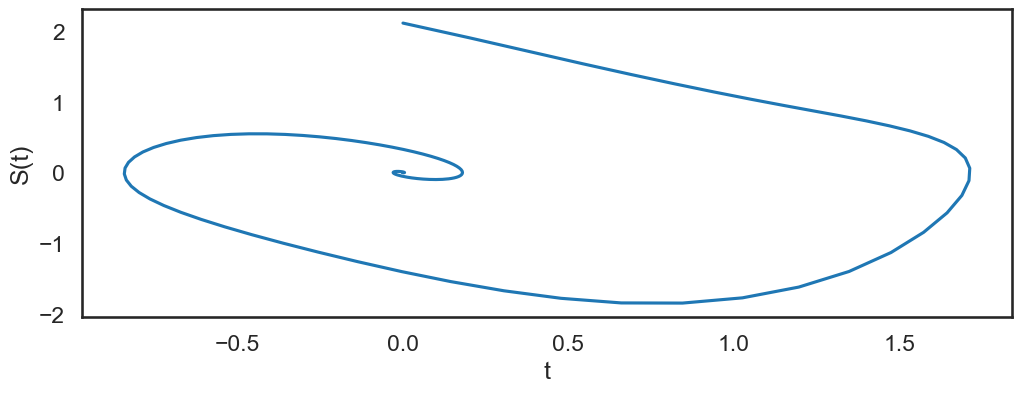

In [29]:
plt.figure(figsize = (12, 4))
plt.plot(sol.y[0], sol.y[1])
plt.xlabel('t')
plt.ylabel('S(t)')

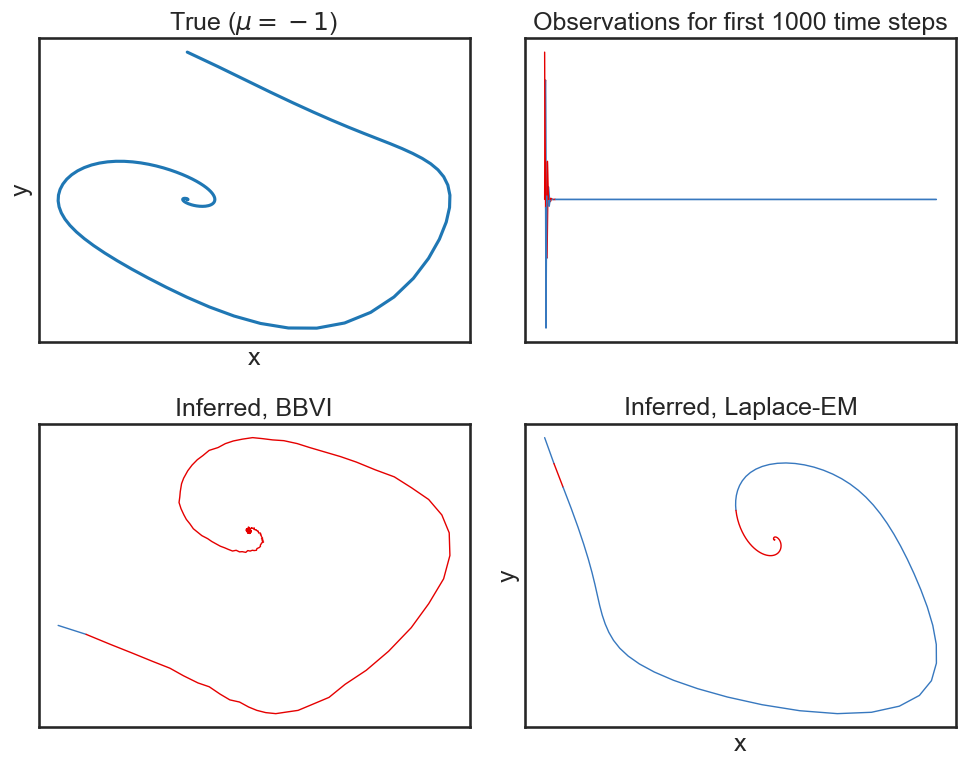

In [30]:
y0 = np.array(y[0])
y1 = np.array(y[1])
plt.figure(figsize=[10,8])
ax1 = plt.subplot(221)
x=y.T
z=(y1>y1.mean()).astype(int)
ax1.plot(y0, y1)
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
plt.title(r"True ($\mu=-1$)")
ax2 =plt.subplot(222)
plot_observations(z[:8000], vdp_data[:8000,:2], ax=ax2)
plt.title("Observations for first 1000 time steps")
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(223)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax3)
plt.title("Inferred, BBVI")
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(224)
plot_trajectory(zhat_lem, xhat_lem, ax=ax4)
plt.title("Inferred, Laplace-EM")
plt.xticks([])
plt.yticks([])
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

Text(0.5, 1.0, 'Inferred Dynamics, BBVI')

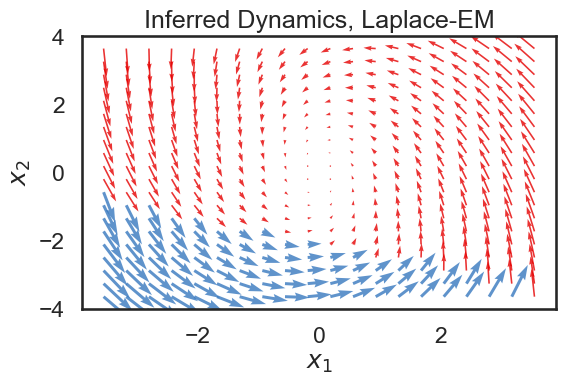

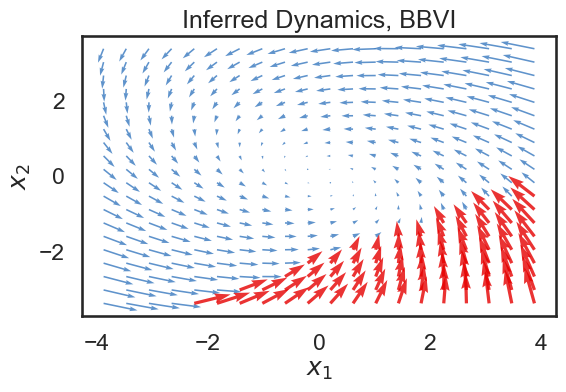

In [61]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, Laplace-EM")

plt.figure(figsize=(6,4))
ax = plt.subplot(111)
lim = abs(xhat_bbvi).max(axis=0) + 1
plot_most_likely_dynamics(rslds, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), ax=ax)
plt.title("Inferred Dynamics, BBVI")

# Van der Pol Multiple Trajectories

In [ ]:
np.random.seed(1)
MU = 1

def vdp(t, y):
    dydt = np.array([y[1], MU*(1-y[0]**2)*y[1]-y[0]])
    return dydt

tmax = 200

num_points = 2  # Number of initial conditions
x_values = np.linspace(-4, 4, num_points)
y_values = np.linspace(-4, 4, num_points)

initial_conditions = []

for x in x_values:
    for y in y_values:
        initial_conditions.append([x, y])

t_eval = np.arange(0, tmax, 0.1)
# initial_conditions = [[2, 0], [1, 0], [3, 0], [4,0]]  # Add more initial conditions as needed

vdp_data = []

for IC in initial_conditions:
    sol = solve_ivp(vdp, [0, tmax], IC, t_eval=t_eval)
    y0 = sol.y[0]
    y1 = sol.y[1]
    noise0 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))
    noise1 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y0))
    data = np.transpose(np.vstack((y0, y1, noise0, noise1)))
    vdp_data.append(data)

vdp_data = np.concatenate(vdp_data, axis=0)

plt.figure(figsize=(12, 4))
for i in range(len(initial_conditions)):
    plt.plot(vdp_data[i*t_eval.size:(i+1)*t_eval.size, 0], vdp_data[i*t_eval.size:(i+1)*t_eval.size, 1], label=f'IC: {initial_conditions[i]}')
plt.xlabel('t')
plt.ylabel('S(t)')
#plt.legend()
plt.show()

y = vdp_data[:,0:2]